# data preprocess

## load and clean data

In [5]:
# load in data
inst = 1
field = 'SWIRE'

datadir='../../doc/20170617_Stacking/maps/PanSTARRScats/'

df1 = pd.read_csv(datadir + field + '1_raw.csv')
df2 = pd.read_csv(datadir + field + '2_raw.csv')
df3 = pd.read_csv(datadir + field + '3_raw.csv')
df4 = pd.read_csv(datadir + field + '4_raw.csv')

In [6]:
# combine the data
df_raw = pd.concat([df1,df2,df3,df4]).drop_duplicates(subset = 'ObjID')
df_raw = df_raw.drop(['ObjID'],axis=1)

In [7]:
# select flag 8 and flag 16 column
flag_arr = df_raw.qualityFlag
bin_values = np.flip(2 ** np.arange(11),0)
flag_bin_arr = np.zeros([len(flag_arr),len(bin_values)],dtype=int)

for i, flag in enumerate(flag_arr):
    bin_str = "{:011b}".format(flag)
    bin_int = list(map(int,list(bin_str)))
    flag_bin_arr[i,:] = bin_int

flag_bin_arr8 = flag_bin_arr[:,int(np.where(bin_values==8)[0])]
flag_bin_arr16 = flag_bin_arr[:,int(np.where(bin_values==16)[0])]

for i,bin_value in enumerate(bin_values):
        df_raw['flag{}'.format(bin_value)] = flag_bin_arr[:,i]
        
df = df_raw[(df_raw.flag8 == 1) | (df_raw.flag16 == 1)].copy()

# select source having band y magnitude
df = df[df.yMeanPSFMag!=-999].copy()
df = df.reset_index(drop=True)

In [8]:
df = df[['ra', 'dec', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag', \
         'gMeanPSFMagErr', 'rMeanPSFMagErr', 'iMeanPSFMagErr', 'zMeanPSFMagErr', 'yMeanPSFMagErr']]

In [9]:
order = [c for c in df.columns]

## add x, y coord

In [10]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord

In [11]:
hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst1/'
xoff = [0,0,512,512]
yoff = [0,512,0,512]
for iquad,quad in enumerate(['A','B','C','D']):
    hdulist = fits.open(hdrdir + 'SWIRE_'+quad+'_astr.fits')
    wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
    hdulist.close()
    src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')
    
    x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
    df['x' + quad] = x_arr + xoff[iquad]
    df['y' + quad] = y_arr + yoff[iquad]

df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

In [12]:
df['x'] = df['xA'].copy()
df['y'] = df['yA'].copy()
for i in range(len(df)):
    if df['meanx'].iloc[i]<511.5 and df['meany'].iloc[i]<511.5:
        df['x'].iloc[i] = df['xA'].iloc[i]
        df['y'].iloc[i] = df['yA'].iloc[i]
    elif df['meanx'].iloc[i]<511.5 and df['meany'].iloc[i]>511.5:
        df['x'].iloc[i] = df['xB'].iloc[i]
        df['y'].iloc[i] = df['yB'].iloc[i]
    elif df['meanx'].iloc[i]>511.5 and df['meany'].iloc[i]<511.5:
        df['x'].iloc[i] = df['xC'].iloc[i]
        df['y'].iloc[i] = df['yC'].iloc[i]
    elif df['meanx'].iloc[i]>511.5 and df['meany'].iloc[i]>511.5:
        df['x'].iloc[i] = df['xD'].iloc[i]
        df['y'].iloc[i] = df['yD'].iloc[i]

order = order[:2] + ['x','y'] + order[2:]
df = df[order]

In [13]:
# select sources inside CIBER map
df = df[(df.x > -0.5) & (df.x < 1023.5) & (df.y > -0.5) & (df.y < 1023.5)].copy()
df = df.reset_index(drop=True)

In [14]:
df.head()

,ra,dec,x,y,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr
0,241.176984,53.768215,1021.373355,1023.279480,21.653601,20.5770,19.969900,19.624001,19.403700,0.053532,0.015777,0.015162,0.013472,0.075818
1,241.281840,53.772379,1020.148111,991.064503,21.367800,20.9069,20.671499,20.563900,19.960199,0.029384,0.026039,0.021093,0.051148,0.209877
2,241.313132,53.770306,1021.489085,981.512716,20.084801,18.9993,18.616100,18.257601,18.060200,0.043773,0.021343,0.005506,0.015000,0.024395
3,241.199316,53.767101,1022.152968,1016.453943,-999.000000,21.3183,19.983700,19.332100,19.202801,-999.000000,0.036554,0.012382,0.012739,0.059966
4,241.307728,53.767064,1023.121113,983.225749,21.991800,21.0711,20.629200,20.245701,19.897600,0.160203,0.049728,0.018776,0.056902,0.283602


# match to UKIDSS

In [15]:
datadir='../../doc/20170617_Stacking/maps/ukidsscats/'
ukdfname = list(pd.read_csv(datadir+field+'.txt',header=0,sep='\s+'))
ukdf = pd.read_csv(datadir+field+'.txt',header=1,sep='\s+',names=ukdfname[1:])

In [16]:
ukdf.head()

,RA,DEC,MERGEDCLASS,PSTAR,PGALAXY,PNOISE,PSATURATED,JAB,JAPERMAG3ERR,HAB,HAPERMAG3ERR,KAB,KAPERMAG3ERR
0,4.234524,0.971383,1,0.003067,0.993865,0.003067,0.0,21.416897,0.044665,-999999490.0,-999999490.0,21.175447,0.051489
1,4.232843,0.971387,-2,0.486486,0.486486,0.027027,0.0,22.627665,0.118260,-999999490.0,-999999490.0,21.256405,0.055072
2,4.237050,0.971393,1,0.003067,0.993865,0.003067,0.0,22.734484,0.129053,-999999490.0,-999999490.0,21.717617,0.081561
3,4.232898,0.971382,1,0.003067,0.993865,0.003067,0.0,18.523575,0.007603,-999999490.0,-999999490.0,18.689423,0.008088
4,4.234252,0.971386,1,0.003067,0.993865,0.003067,0.0,20.198942,0.019371,-999999490.0,-999999490.0,19.368803,0.012664


In [17]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

coorduk = SkyCoord(ra=ukdf['RA']*180./np.pi*u.degree, dec=ukdf['DEC']*180./np.pi*u.degree,\
                   frame='icrs')
coordps = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

idx, d2d,_ = match_coordinates_sky(coordps, coorduk)
df['mergedClass'] = np.array(ukdf.iloc[idx].MERGEDCLASS)

In [18]:
dfpreprocess = df.copy()

In [19]:
dfpreprocess.head()

,ra,dec,x,y,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,mergedClass
0,241.176984,53.768215,1021.373355,1023.279480,21.653601,20.5770,19.969900,19.624001,19.403700,0.053532,0.015777,0.015162,0.013472,0.075818,1
1,241.281840,53.772379,1020.148111,991.064503,21.367800,20.9069,20.671499,20.563900,19.960199,0.029384,0.026039,0.021093,0.051148,0.209877,-1
2,241.313132,53.770306,1021.489085,981.512716,20.084801,18.9993,18.616100,18.257601,18.060200,0.043773,0.021343,0.005506,0.015000,0.024395,1
3,241.199316,53.767101,1022.152968,1016.453943,-999.000000,21.3183,19.983700,19.332100,19.202801,-999.000000,0.036554,0.012382,0.012739,0.059966,1
4,241.307728,53.767064,1023.121113,983.225749,21.991800,21.0711,20.629200,20.245701,19.897600,0.160203,0.049728,0.018776,0.056902,0.283602,1


# Write lephare input file

In [20]:
df_lph = df[['gMeanPSFMag','gMeanPSFMagErr','rMeanPSFMag','rMeanPSFMagErr','iMeanPSFMag','iMeanPSFMagErr',\
          'zMeanPSFMag','zMeanPSFMagErr','yMeanPSFMag','yMeanPSFMagErr']]
df_lph.index += 1

In [21]:
df_lph.head()

,gMeanPSFMag,gMeanPSFMagErr,rMeanPSFMag,rMeanPSFMagErr,iMeanPSFMag,iMeanPSFMagErr,zMeanPSFMag,zMeanPSFMagErr,yMeanPSFMag,yMeanPSFMagErr
1,21.653601,0.053532,20.5770,0.015777,19.969900,0.015162,19.624001,0.013472,19.403700,0.075818
2,21.367800,0.029384,20.9069,0.026039,20.671499,0.021093,20.563900,0.051148,19.960199,0.209877
3,20.084801,0.043773,18.9993,0.021343,18.616100,0.005506,18.257601,0.015000,18.060200,0.024395
4,-999.000000,-999.000000,21.3183,0.036554,19.983700,0.012382,19.332100,0.012739,19.202801,0.059966
5,21.991800,0.160203,21.0711,0.049728,20.629200,0.018776,20.245701,0.056902,19.897600,0.283602


In [99]:
savedir = '~/ciber/lephare/lephare_dev/panstarrs/'
df_lph.to_csv(savedir + 'SWIRE.in',sep=' ',header=False, float_format='%.3e')

# run lephere photo-z fitting

# lephere result process

In [93]:
df = dfpreprocess.copy()

In [82]:
loaddir = '/Users/ytcheng/ciber/lephare/lephare_dev/panstarrs/'
data = np.loadtxt(loaddir + 'SWIRE.out')

In [94]:
nband_use = np.array([data[:,12]-2,data[:,12]-3,data[:,12]-3]).T
# star, gal, qso
chi = np.array(data[:,[20,5,17]])
chi = chi / nband_use

# 3 type classification
# 0 - star, 1 - gal, 2 - qso
lph_class3 = np.argmin(chi,axis=1)
# -1 - star, 1 - gal, 2 - qso
lph_class3[lph_class3==0] = -1
# set dof = 0 src to -999
lph_class3[nband_use[:,1]<=0] = -999

# 2 type classification
# 0 - star, 1 - gal
lph_class = np.argmin(chi[:,:2],axis=1)
# -1 - star, 1 - gal
lph_class[lph_class==0] = -1
# set dof = 0 src to 3
lph_class[nband_use[:,1]<=0] = -999


df['z_gal'] = data[:,1]
df['z_qso'] = data[:,16]
df['dof_gal'] = np.array(nband_use[:,1], dtype=int)
df['chi2_star'] = data[:,20]
df['chi2_gal'] = data[:,5]
df['chi2_qso'] = data[:,17]
df['lphClass3'] = lph_class3
df['lphClass'] = lph_class

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


In [95]:
dflephere = df.copy()

In [96]:
dflephere.head()

,ra,dec,x,y,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,...,yMeanPSFMagErr,mergedClass,z_gal,z_qso,dof_gal,chi2_star,chi2_gal,chi2_qso,lphClass3,lphClass
0,241.850863,53.779051,1020.821047,816.781055,19.596600,19.621901,19.757401,19.925699,19.837900,0.018753,...,0.040693,-1,2.5413,2.84,2,21.02900,41.485000,154.719000,-1,-1
1,241.978114,53.781721,1020.149568,777.847193,19.973301,19.458401,19.261000,19.154301,19.032101,0.028338,...,0.048942,1,0.5089,2.88,2,5.74502,0.624177,1.232070,1,1
2,241.996467,53.781784,1020.212717,772.237430,20.432600,19.341200,18.842199,18.564699,18.386499,0.019214,...,0.015915,-1,0.5049,3.12,2,26.76590,4.775810,25.354800,1,1
3,241.199316,53.767101,1022.152968,1016.453943,-999.000000,21.318300,19.983700,19.332100,19.202801,-999.000000,...,0.059966,1,0.7870,5.44,1,14.20090,13.030100,0.989434,2,-1
4,241.294344,53.774071,1019.379924,987.202994,-999.000000,21.685499,21.249500,20.554399,20.049299,-999.000000,...,0.084169,1,1.2607,2.60,1,21.93150,0.061602,0.695842,1,1


In [106]:
fname = field + '_lephare.csv'
dflephere.to_csv(fname,index=False)

# Examine the results

In [76]:
df = dflephere[['x','y','mergedClass','lphClass3','lphClass','z_gal','z_qso',\
               'gMeanPSFMag','rMeanPSFMag','iMeanPSFMag','zMeanPSFMag','yMeanPSFMag',\
                'chi2_star','chi2_gal','chi2_qso']].copy()

In [77]:
savedir = '/Users/ytcheng/ciber/doc/20180313_lephare/plots/'

## magnitude histogram

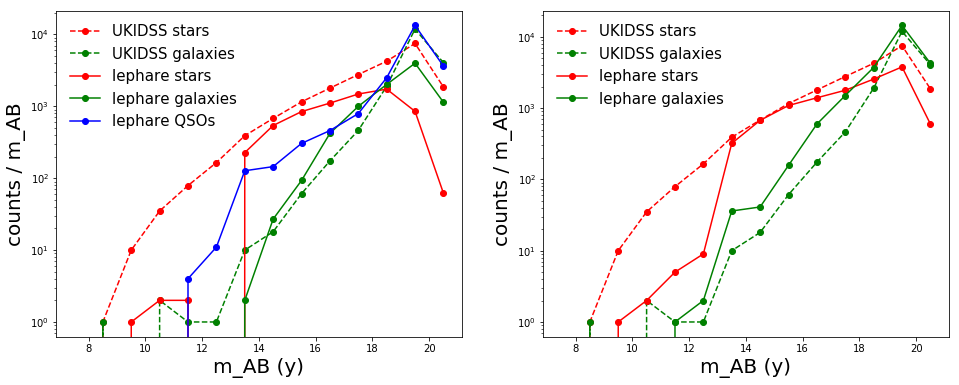

In [78]:
for _ in [0]:
    fig, ax = plt.subplots(1,2,figsize=(16,6))

    binedges = np.arange(7,22,1)
    bins = (binedges[:-1] + binedges[1:])/2

    shist,_ = np.histogram(df['yMeanPSFMag'][(df.mergedClass==-1)], bins = binedges)
    ax[0].plot(bins,shist,'ro--',label='UKIDSS stars')
    ax[1].plot(bins,shist,'ro--',label='UKIDSS stars')
    ghist,_ = np.histogram(df['yMeanPSFMag'][(df.mergedClass==1)], bins = binedges)
    ax[0].plot(bins,ghist,'go--',label='UKIDSS galaxies')
    ax[1].plot(bins,ghist,'go--',label='UKIDSS galaxies')
    
    shist,_ = np.histogram(df['yMeanPSFMag'][(df.lphClass3==-1)], bins = binedges)
    ax[0].plot(bins,shist,'ro-',label='lephare stars')
    ghist,_ = np.histogram(df['yMeanPSFMag'][(df.lphClass3==1)], bins = binedges)
    ax[0].plot(bins,ghist,'go-',label='lephare galaxies')
    ghist,_ = np.histogram(df['yMeanPSFMag'][(df.lphClass3==2)], bins = binedges)
    ax[0].plot(bins,ghist,'bo-',label='lephare QSOs')

    shist,_ = np.histogram(df['yMeanPSFMag'][(df.lphClass==-1)], bins = binedges)
    ax[1].plot(bins,shist,'ro-',label='lephare stars')
    ghist,_ = np.histogram(df['yMeanPSFMag'][(df.lphClass==1)], bins = binedges)
    ax[1].plot(bins,ghist,'go-',label='lephare galaxies')
    
    ax[0].set_yscale('log')
    ax[0].set_xlabel('m_AB (y)',fontsize=20)
    ax[0].set_ylabel('counts / m_AB',fontsize=20)
    ax[0].legend(loc=0, frameon = False,fontsize=15)

    ax[1].set_yscale('log')
    ax[1].set_xlabel('m_AB (y)',fontsize=20)
    ax[1].set_ylabel('counts / m_AB',fontsize=20)
    ax[1].legend(loc=0, frameon = False,fontsize=15)

    #fig.savefig(savedir + field + 'mag_hist', dpi = 256, bbox_inches='tight')

## redshift histogram

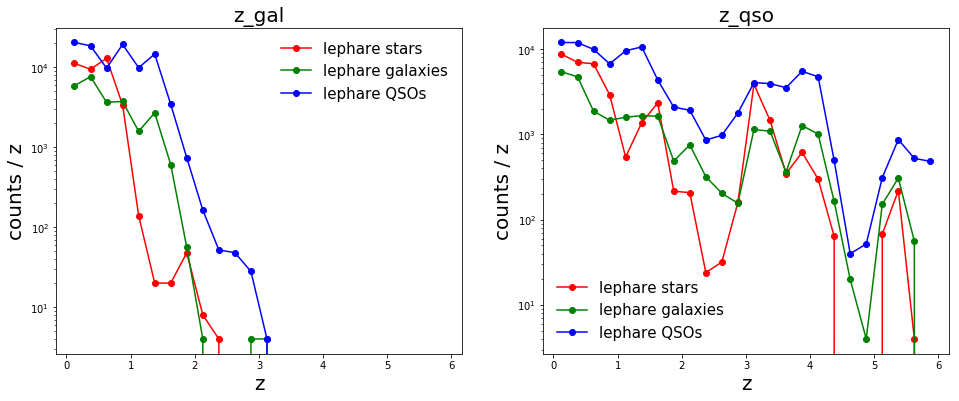

In [132]:
for _ in [0]:
    fig, ax = plt.subplots(1,2,figsize=(16,6))

    binedges = np.arange(0,6.1,0.25)
    bins = (binedges[:-1] + binedges[1:])/2

    shist,_ = np.histogram(df['z_gal'][(df.lphClass==-1)], bins = binedges)
    ax[0].plot(bins,shist / (binedges[1]-binedges[0]),'ro-',label='lephare stars')
    ghist,_ = np.histogram(df['z_gal'][(df.lphClass==1)], bins = binedges)
    ax[0].plot(bins,ghist / (binedges[1]-binedges[0]),'go-',label='lephare galaxies')
    ghist,_ = np.histogram(df['z_gal'][(df.lphClass==2)], bins = binedges)
    ax[0].plot(bins,ghist / (binedges[1]-binedges[0]),'bo-',label='lephare QSOs')

    ax[0].set_yscale('log')
    ax[0].set_xlabel('z',fontsize=20)
    ax[0].set_ylabel('counts / z',fontsize=20)
    ax[0].set_title('z_gal',fontsize=20)
    ax[0].legend(loc=0, frameon = False,fontsize=15)
    
    shist,_ = np.histogram(df['z_qso'][(df.lphClass==-1)], bins = binedges)
    ax[1].plot(bins,shist / (binedges[1]-binedges[0]),'ro-',label='lephare stars')
    ghist,_ = np.histogram(df['z_qso'][(df.lphClass==1)], bins = binedges)
    ax[1].plot(bins,ghist / (binedges[1]-binedges[0]),'go-',label='lephare galaxies')
    ghist,_ = np.histogram(df['z_qso'][(df.lphClass==2)], bins = binedges)
    ax[1].plot(bins,ghist / (binedges[1]-binedges[0]),'bo-',label='lephare QSOs')

    ax[1].set_yscale('log')
    ax[1].set_xlabel('z',fontsize=20)
    ax[1].set_ylabel('counts / z',fontsize=20)
    ax[1].set_title('z_qso',fontsize=20)
    ax[1].legend(loc=0, frameon = False,fontsize=15)
    
    fig.savefig(savedir + field + 'mag_z', dpi = 256, bbox_inches='tight')

## x,y distribution

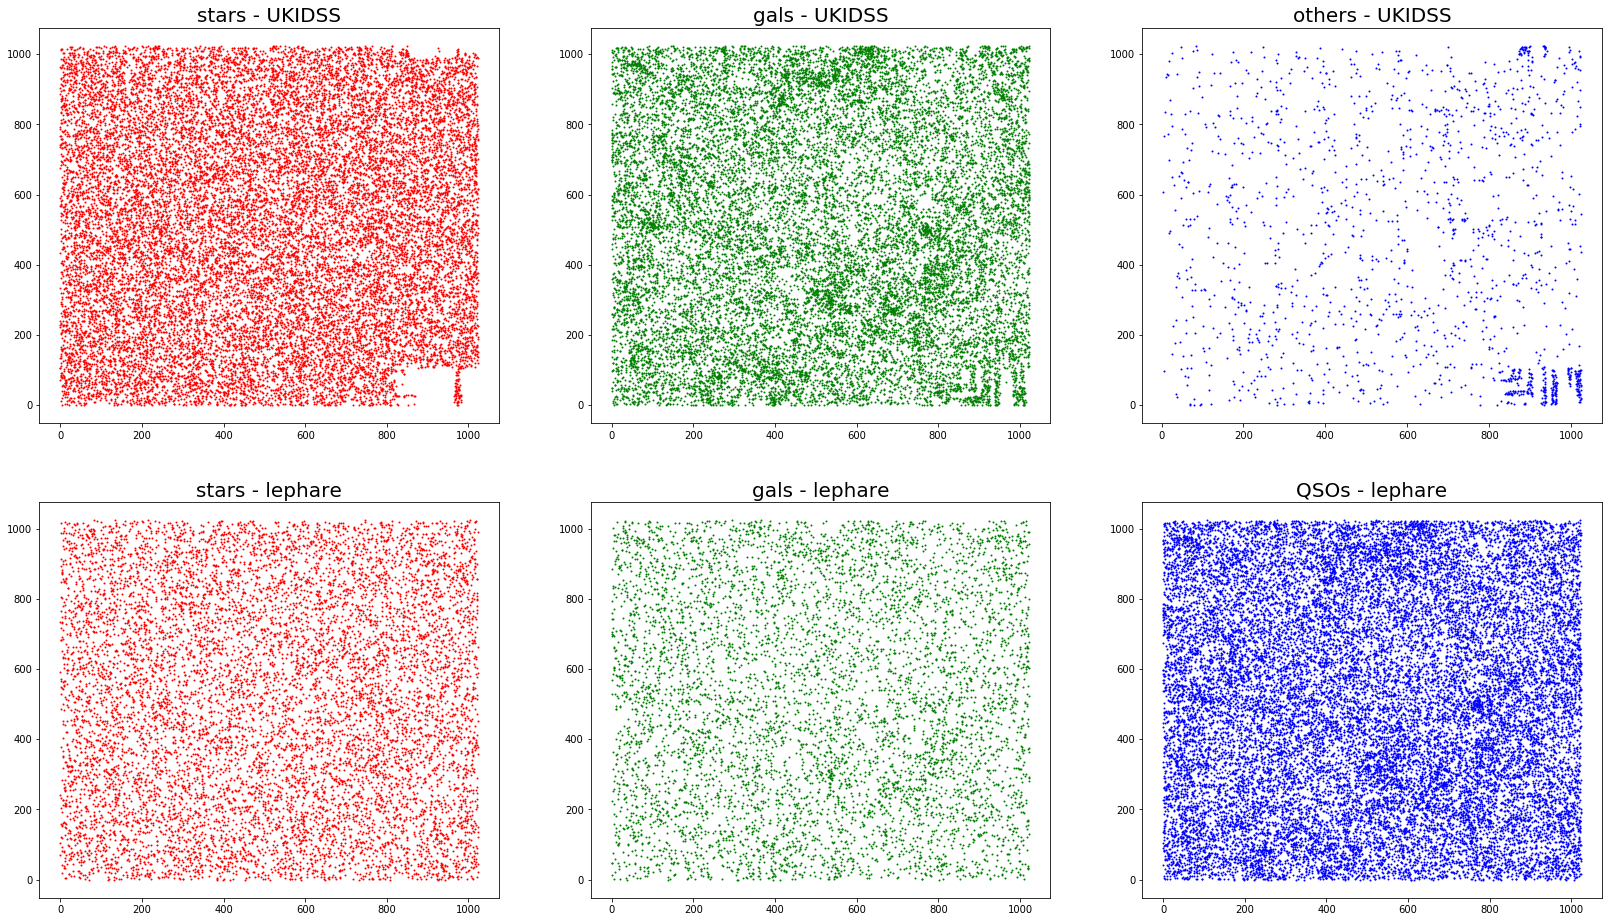

In [172]:
for _ in [0]:
    fig, ax = plt.subplots(2,3,figsize=(28,16))

    ax[0][0].plot(df['x'][(df.mergedClass==-1)],df['y'][(df.mergedClass==-1)],'ro', linestyle='', ms=1)
    ax[0][0].set_title('stars - UKIDSS',fontsize=20)
    ax[0][1].plot(df['x'][(df.mergedClass==1)],df['y'][(df.mergedClass==1)],'go', linestyle='', ms=1)
    ax[0][1].set_title('gals - UKIDSS',fontsize=20)
    ax[0][2].plot(df['x'][(df.mergedClass!=1) & (df.mergedClass!=-1)],\
                  df['y'][(df.mergedClass!=1) & (df.mergedClass!=-1)],'bo', linestyle='', ms=1)
    ax[0][2].set_title('others - UKIDSS',fontsize=20)


    ax[1][0].plot(df['x'][(df.lphClass==-1)],df['y'][(df.lphClass==-1)],'ro', linestyle='', ms=1)
    ax[1][0].set_title('stars - lephare',fontsize=20)
    ax[1][1].plot(df['x'][(df.lphClass==1)],df['y'][(df.lphClass==1)],'go', linestyle='', ms=1)
    ax[1][1].set_title('gals - lephare',fontsize=20)
    ax[1][2].plot(df['x'][(df.lphClass==2)],df['y'][(df.lphClass==2)],'bo', linestyle='', ms=1)
    ax[1][2].set_title('QSOs - lephare',fontsize=20)
    
    fig.savefig(savedir + field + 'xy', dpi = 256, bbox_inches='tight')

## $\chi^2$

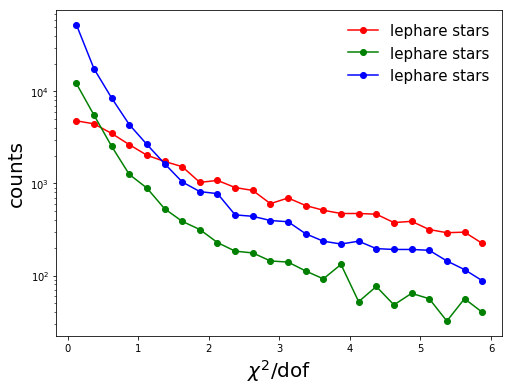

In [221]:
for _ in [0]:
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    binedges = np.arange(0,6.1,0.25)
    bins = (binedges[:-1] + binedges[1:])/2
    
    chi2 = np.array(df['chi2_star'][(df.lphClass==-1)])
    dof = np.array(df['gMeanPSFMag']>-998, dtype=int) + np.array(df['rMeanPSFMag']>-998, dtype=int) + \
        np.array(df['iMeanPSFMag']>-998, dtype=int) + np.array(df['zMeanPSFMag']>-998, dtype=int) + \
        np.array(df['yMeanPSFMag']>-998, dtype=int)
    dof = dof[(df.lphClass==-1)]
    shist,_ = np.histogram(chi2 / dof, bins = binedges)
    ax.plot(bins,shist / (binedges[1]-binedges[0]),'ro-',label='lephare stars')

    chi2 = np.array(df['chi2_gal'][(df.lphClass==1)])
    dof = np.array(df['gMeanPSFMag']>-998, dtype=int) + np.array(df['rMeanPSFMag']>-998, dtype=int) + \
        np.array(df['iMeanPSFMag']>-998, dtype=int) + np.array(df['zMeanPSFMag']>-998, dtype=int) + \
        np.array(df['yMeanPSFMag']>-998, dtype=int)
    dof = dof[(df.lphClass==1)]
    shist,_ = np.histogram(chi2 / dof, bins = binedges)
    ax.plot(bins,shist / (binedges[1]-binedges[0]),'go-',label='lephare stars')

    chi2 = np.array(df['chi2_qso'][(df.lphClass==2)])
    dof = np.array(df['gMeanPSFMag']>-998, dtype=int) + np.array(df['rMeanPSFMag']>-998, dtype=int) + \
        np.array(df['iMeanPSFMag']>-998, dtype=int) + np.array(df['zMeanPSFMag']>-998, dtype=int) + \
        np.array(df['yMeanPSFMag']>-998, dtype=int)
    dof = dof[(df.lphClass==2)]
    shist,_ = np.histogram(chi2 / dof, bins = binedges)
    ax.plot(bins,shist / (binedges[1]-binedges[0]),'bo-',label='lephare stars')
    
    ax.set_yscale('log')
    ax.set_xlabel('$\chi^2$/dof',fontsize=20)
    ax.set_ylabel('counts',fontsize=20)
    ax.legend(loc=0, frameon = False,fontsize=15)
    
    fig.savefig(savedir + field + 'chi2', dpi = 256, bbox_inches='tight')

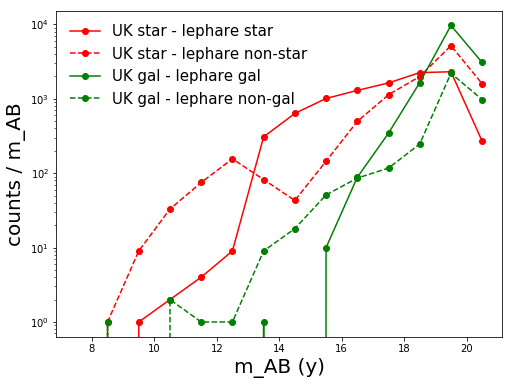

In [79]:
for _ in [0]:
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    binedges = np.arange(7,22,1)
    bins = (binedges[:-1] + binedges[1:])/2
    
    Ns_right=np.zeros(len(bins), dtype=int)
    Ng_right=np.zeros(len(bins), dtype=int)
    Ns_wrong=np.zeros(len(bins), dtype=int)
    Ng_wrong=np.zeros(len(bins), dtype=int)
    for i in range(len(bins)):
        bin_min = binedges[i]
        bin_max = binedges[i+1]
        Ns_right[i] = len(df[(df.lphClass==-1) & (df.mergedClass==-1) & \
                         (df.yMeanPSFMag>=bin_min) & (df.yMeanPSFMag<bin_max)])
        Ns_wrong[i] = len(df[(df.lphClass!=-1) & (df.mergedClass==-1) & \
                         (df.yMeanPSFMag>=bin_min) & (df.yMeanPSFMag<bin_max)])
        Ng_right[i] = len(df[(df.lphClass==1) & (df.mergedClass==1) & \
                         (df.yMeanPSFMag>=bin_min) & (df.yMeanPSFMag<bin_max)])
        Ng_wrong[i] = len(df[(df.lphClass!=1) & (df.mergedClass==1) & \
                         (df.yMeanPSFMag>=bin_min) & (df.yMeanPSFMag<bin_max)])
    
    ax.plot(bins, Ns_right,'ro-', label = 'UK star - lephare star')
    ax.plot(bins, Ns_wrong,'ro--', label = 'UK star - lephare non-star')
    ax.plot(bins, Ng_right,'go-', label = 'UK gal - lephare gal')
    ax.plot(bins, Ng_wrong,'go--', label = 'UK gal - lephare non-gal')
    
    ax.set_yscale('log')
    ax.set_xlabel('m_AB (y)',fontsize=20)
    ax.set_ylabel('counts / m_AB',fontsize=20)
    ax.legend(loc=0, frameon = False,fontsize=15)
    
    fig.savefig(savedir + field + 'identification', dpi = 256, bbox_inches='tight')